In [10]:
%matplotlib notebook

from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib

import cpvlib

from sistemas_irr_dni import genera_pot_cpv, genera_pot_pv

In [11]:
lat, lon = 40.4, -3.7
tilt = lat - 10

diffuse_model = 'haydavies'

eff_opt_cpv = 0.87
eff_opt_pv = 0.70

spillage_factor = 0.02

aoi_limit = 90

In [12]:
data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

alt = data_pvgis[2]['location']['elevation']

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=alt, tz='utc')

solpos = location.get_solarposition(data.index)

C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:206: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)
C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:713: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


<IPython.core.display.Javascript object>


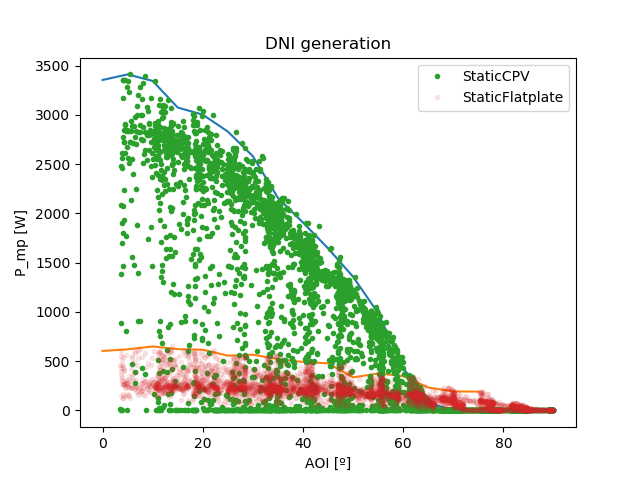

punto_corte=62
aumento_pot_dni_pv_respecto_cpv=0.4%


In [24]:
cpv_power_p_mp, aoi, cpv_irradiance_spillage = genera_pot_cpv(location, solpos, data, tilt, eff_opt_cpv, spillage_factor)
pv_power,_ = genera_pot_pv(location, solpos, data, diffuse_model, tilt, aoi_limit, eff_opt_pv, cpv_irradiance_spillage)

a, b = [], []
step = 5
v_aoi = np.array(range(0,80,step))
for daoi in v_aoi:
    a.append(cpv_power_p_mp[(daoi<aoi) & (aoi<daoi+step)].max())
    b.append(pv_power['p_mp'][(daoi<aoi) & (aoi<daoi+step)].max())

a, b = pd.Series(data=a, index=v_aoi), pd.Series(data=b, index=v_aoi)
plt.plot(v_aoi, a, v_aoi, b)

punto_corte = np.interp(0, -1*(a-b), -1*v_aoi)*-1

plt.plot(aoi[aoi<90], cpv_power_p_mp[aoi<90], '.', label='StaticCPV')
plt.plot(aoi[aoi<90], pv_power['p_mp'][aoi<90], '.', alpha=0.1, label='StaticFlatplate')
plt.legend()
plt.title('DNI generation')
plt.ylabel('P_mp [W]')
plt.xlabel('AOI [º]')

condicion = (aoi > punto_corte) & (cpv_power_p_mp > 0)
aumento_pot_dni_pv_respecto_cpv = ((pv_power['p_mp'][condicion]).sum() - (cpv_power_p_mp[condicion]).sum()) / cpv_power_p_mp.sum()

print(f"punto_corte={punto_corte:.0f}º")
print(f"aumento_pot_dni_pv_respecto_cpv={aumento_pot_dni_pv_respecto_cpv:.1%}")